In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.cm import ScalarMappable
%matplotlib widget

import importlib
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import ExperimentClass
import tools
import math_functions as mf


In [39]:
importlib.reload(ExperimentClass)
importlib.reload(tools)
importlib.reload(mf)

<module 'math_functions' from 'c:\\Users\\Orlando\\Desktop\\DREAM_repo\\math_functions.py'>

In [40]:
import ast
import re

def fix_number_format(value):
    if isinstance(value, str):
        # Add a comma after an integer followed by a float
        value = re.sub(r'(\d+)\.\s+(\d)', r'\1., \2', value)
        
        # Add commas between numbers wherever necessary
        value = re.sub(r'(?<=\d)\s+(?=[\d\.])', ', ', value)
    return value

def convert_to_list(value):
    if isinstance(value, str):
        try:
            return ast.literal_eval(value)
        except Exception as e:
            print(f"Error converting value: {value}, error: {e}")
            return value
    return value

# Apply this function to the relevant columns
columns_to_convert = ['F_max', 'F_stat', 'phi_stat', 'NPQ', 'ETR']


In [41]:
PSI_folder = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI"
list_path = "C:/Users/Orlando/ownCloud - ORLANDO Marcelo@mycore.cnrs.fr/Doutorado/Dados experimentais/PSI/00_experiments_lists/"
exp_list = pd.read_csv(list_path + "20241203_chlamy_activation_curve_list.csv", sep=";", decimal=",")
exp_list

,Name,Strain,Label,Time_start,Date,Replicate,Cell_count_mL
0,20241203_activation_stt71A6,stt7,control,11.0,03/12/2024,1,803000.0
1,20241204_activation_stt71A6,stt7,control,10.5,04/12/2024,2,599000.0
2,20241205_activation_stt71A6,stt7,control,14.0,05/12/2024,0,1170000.0
3,20241206_activation_stt71A6,stt7,control,11.5,06/12/2024,3,1100000.0


In [42]:
exp_list[(exp_list['Name'] == name)]['Replicate'].values[0]

3

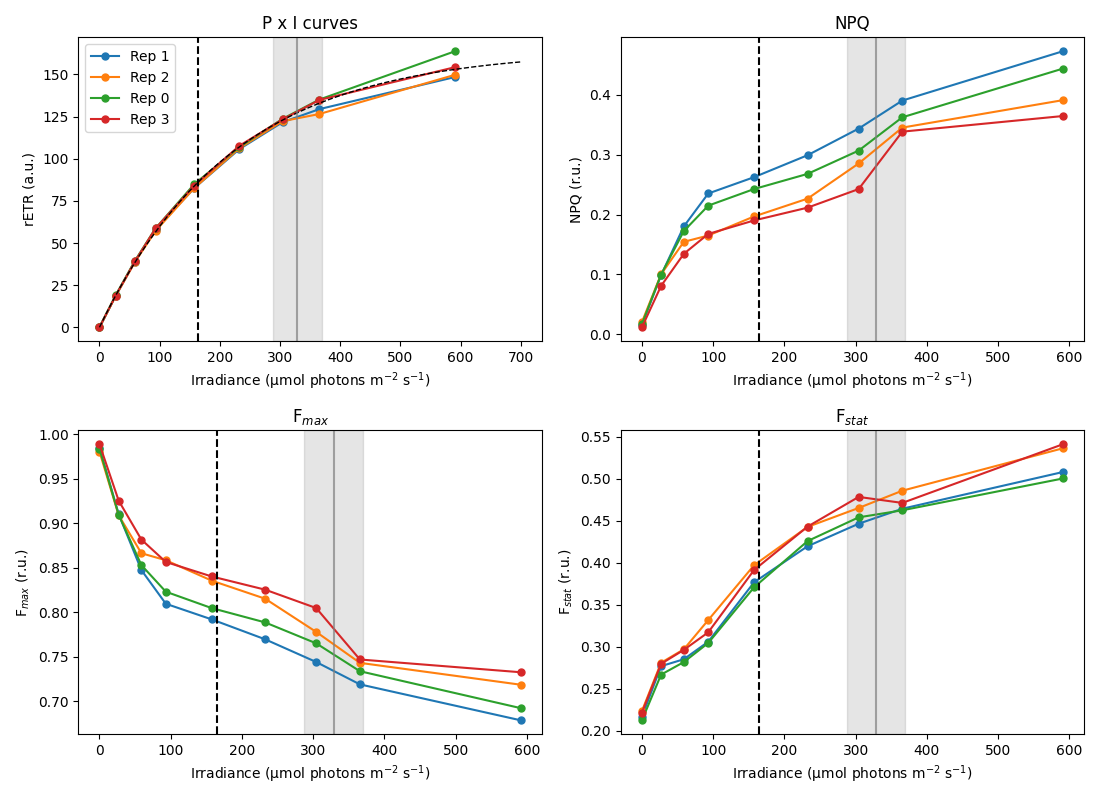

In [43]:
marker = 5
alpha = 1
Ek_offset = 2
Ek_amp = 0.25

end_ETR_fit = 9
n_Fmax_ETR = 2

strains = ["stt7"]
fig, ax = plt.subplots(2,2, figsize=(11,8))

all_ETR = []
labels = []

for i, strain in enumerate(strains):
    names = exp_list[(exp_list["Strain"] == strain)]["Name"].to_list()
    labels.append(strain + f"({exp_list[exp_list.Name == names[0]]['Label'].values[0]})")

    ETR = []
    NPQ = []
    F_max = []
    F_stat = []
    
    for j,  name in enumerate(names):
        path = f"{PSI_folder}/{name}/params.csv"
        params = pd.read_csv(path, index_col= False, sep=";")
        for column in columns_to_convert:
            params[column] = params[column].apply(fix_number_format)
            params[column] = params[column].apply(convert_to_list)
        ETR.append([params.ETR[k][n_Fmax_ETR] for k in params.index])
        NPQ.append([params.NPQ[k][n_Fmax_ETR] for k in params.index])
        F_max.append([params.F_max[k][n_Fmax_ETR] for k in params.index])
        F_stat.append([params.F_stat[k][n_Fmax_ETR] for k in params.index])
        
        ax[0, 0].plot(params.Actinic, ETR[-1], '-o', markersize = marker, alpha = alpha, color = f"C{j}", label = f"Rep {exp_list[(exp_list['Name'] == name)]['Replicate'].values[0]}")
        ax[0, 1].plot(params.Actinic, NPQ[-1], '-o', markersize = marker, alpha = alpha, color = f"C{j}")
        ax[1, 0].plot(params.Actinic, F_max[-1], '-o', markersize = marker, alpha = alpha, color = f"C{j}")
        ax[1, 1].plot(params.Actinic, F_stat[-1], '-o', markersize = marker, alpha = alpha, color = f"C{j}")
    
    
    all_ETR.append(ETR)
    ETR = np.array(ETR)
    NPQ = np.array(NPQ)
    F_max = np.array(F_max)
    F_stat = np.array(F_stat)
    
    # ax[0, 0].errorbar(params.Actinic, ETR.mean(axis=0), yerr = ETR.std(axis=0), fmt = '-', color = f"C{i}", label = labels[i], capsize = 5)
    # ax[0, 1].errorbar(params.Actinic, NPQ.mean(axis=0), yerr = NPQ.std(axis=0), fmt = '-', color = f"C{i}", label = labels[i], capsize = 5)
    # ax[1, 0].errorbar(params.Actinic, F_max.mean(axis=0), yerr = F_max.std(axis=0), fmt = '-', color = f"C{i}", label = labels[i], capsize = 5)
    # ax[1, 1].errorbar(params.Actinic, F_stat.mean(axis=0), yerr = F_stat.std(axis=0), fmt = '-', color = f"C{i}", label = labels[i], capsize = 5)
    
all_data_array = np.array([replicate for condition in all_ETR for replicate in condition])
average = np.mean(all_data_array, axis = 0)
popt, pcov, xfit, yfit = tools.Ek_fit(params.Actinic[:end_ETR_fit], average[:end_ETR_fit], 0, 700, 100, p0=[100, 100])
Ek = popt[0]
ax[0,0].plot(xfit, yfit, '--', color="k", linewidth=1)

for ax_ in ax.flatten():
    ylim = ax_.get_ylim()
    ax_.axvline(Ek, color = "k", linestyle = "--")
    ax_.axvline(Ek*Ek_offset, color = "gray", linestyle = "-", alpha = 0.7)
    ax_.fill_betweenx(ylim, Ek*Ek_offset - Ek*Ek_amp, Ek*Ek_offset + Ek*Ek_amp, color = "k", alpha = 0.1)
    ax_.set_ylim(ylim)
    ax_.set_xlabel("Irradiance (µmol photons m$^{-2}$ s$^{-1}$)")

ax[0,0].set_ylabel("rETR (a.u.)")
ax[0,1].set_ylabel("NPQ (r.u.)")
ax[1,0].set_ylabel("F$_{max}$ (r.u.)")
ax[1,1].set_ylabel("F$_{stat}$ (r.u.)")
ax[0,0].legend()

ax[0,0].set_title("P x I curves")
ax[0,1].set_title("NPQ")
ax[1,0].set_title("F$_{max}$")
ax[1,1].set_title("F$_{stat}$")

fig.tight_layout()
        
        